# Defense

Is it typically the case that the color classes in a NAC-coloring are balanced with respect to the two colors (especially when the graph has only few NAC-colorings)?
Or does it often happen (in practice) that there exists some NAC-coloring that is largely biased towards one of the two colors?

In [2]:
from typing import *
from dataclasses import dataclass
from collections import defaultdict, deque
import random
import importlib
from random import Random
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline
from matplotlib.backends import backend_agg
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

import numpy as np
import pandas as pd
import networkx as nx
import os
import time
import datetime
import signal
import itertools
import base64

from tqdm import tqdm

import nac as nac
from nac import MonochromaticClassType

import benchmarks
from benchmarks import datasets
from benchmarks import generators
import benchmarks.notebook_utils
from benchmarks.notebook_utils import *

seed=42
TEST=False
BENCHMARKS=False
ANALYTICS=True
SEARCH=False


In [3]:
importlib.reload(nac)
importlib.reload(benchmarks.datasets)
importlib.reload(benchmarks.generators)
importlib.reload(benchmarks)
importlib.reload(benchmarks.notebook_utils)

_BENCH_FILE_START_V2 = "bench_res_v2"
_BENCH_FILE_START_V3 = "bench_res_v3"
_BENCH_FILE_START_V4 = "bench_res_v4"

OUTPUT_DIR = os.path.join("benchmarks", "runs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

benchmarks.notebook_utils.OUTPUT_DIR = OUTPUT_DIR
benchmarks.notebook_utils.OUTPUT_BENCH_FILE_START = _BENCH_FILE_START_V4
benchmarks.notebook_utils.OUTPUT_VERBOSE = False

In [4]:
from nac import NAC_colorings, canonical_NAC_coloring
import numpy as np

In [5]:
df = load_records()

Found file: bench_res_v4_2025-05-12_23-00-24.csv


In [6]:
def evaluate(df: pd.DataFrame, sample_size: int = 1000, random_state: int = 42) -> dict[nx.Graph, list[Tuple[Container, Container]]]:
    df = df.sample(sample_size, random_state=random_state)
    res = dict()
    for graph in tqdm(df['graph']):
        graph = graph_from_id(graph)
        res[graph] = list(NAC_colorings(graph))
    return res

In [7]:
def analyze(data: list[list[tuple[Container, Container]]]) -> pd.DataFrame:
    ratios: list[tuple[float, float]] = []
    for record in data:
        colorings = set(canonical_NAC_coloring(col) for col in record)
        item_weight = 1/len(colorings)
        for col in colorings:
            if len(col[0]) > len(col[1]):
                col = (col[1], col[0])
            ratios.append((len(col[0]) / len(col[1]), item_weight))
    df = pd.DataFrame(ratios, columns=["ratio", "weight"])
    df.sort_values(by="ratio", inplace=True)
    return df

In [8]:
def showcase(df: pd.DataFrame) -> None:
    print("Count:", len(df))
    display(df["ratio"].describe())
    print("Weighted average:", np.average(df["ratio"], weights=df["weight"]))
    df["ratio"].hist(bins=20)

## Minimally rigid

In [9]:
min_rigid = df.query("dataset == 'minimally_rigid_random' and nac_all_coloring_no > 0 and vertex_no >= 18")
len(min_rigid)

5078

In [10]:
min_rigid_colorings = evaluate(min_rigid)

100%|██████████| 1000/1000 [13:56<00:00,  1.20it/s]


In [11]:
min_ser = analyze(min_rigid_colorings.values())

Count: 1602001


count    1.602001e+06
mean     6.294629e-01
std      2.120537e-01
min      6.060606e-02
25%      4.583333e-01
50%      6.500000e-01
75%      8.333333e-01
max      9.444444e-01
Name: ratio, dtype: float64

Weighted average: 0.5953819693215459


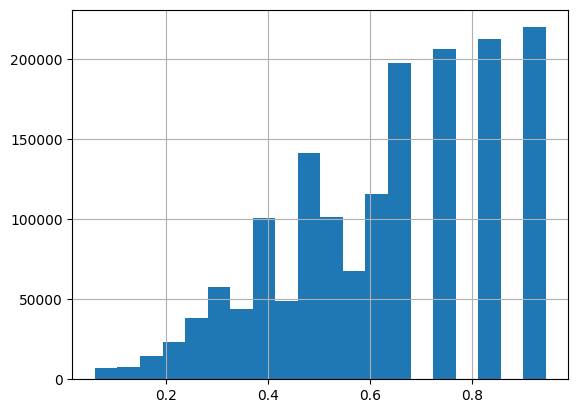

In [12]:
showcase(min_ser)

## Globally rigid

### Single NAC-coloring

In [13]:
glob_rigid_single = df.query("dataset == 'globally_rigid' and nac_all_coloring_no > 0 and vertex_no >= 18 and nac_all_coloring_no <= 2")
len(glob_rigid_single)

1319

In [14]:
glob_rigid_single_colorings = evaluate(glob_rigid_single)

100%|██████████| 1000/1000 [00:15<00:00, 63.95it/s]


In [15]:
glob_single_ser = analyze(glob_rigid_single_colorings.values())

Count: 1000


count    1000.000000
mean        0.091034
std         0.090175
min         0.051724
25%         0.062500
50%         0.069767
75%         0.085106
max         0.846154
Name: ratio, dtype: float64

Weighted average: 0.0910342163171683


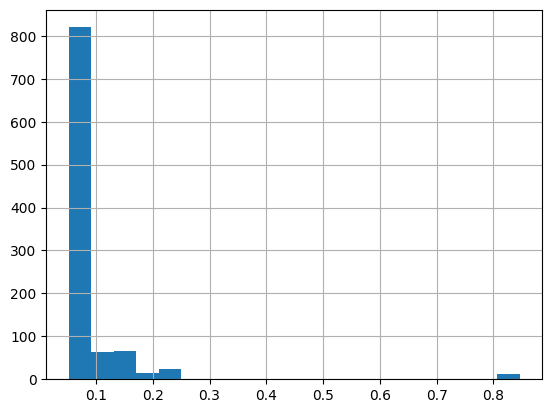

In [16]:
showcase(glob_single_ser)

### Few NAC-coloring

In [17]:
glob_rigid_few = df.query("dataset == 'globally_rigid' and nac_all_coloring_no > 0 and vertex_no >= 18 and nac_all_coloring_no <= 20")
len(glob_rigid_few)

3750

In [18]:
glob_rigid_few_colorings = evaluate(glob_rigid_few)

100%|██████████| 1000/1000 [00:16<00:00, 62.15it/s]


In [19]:
glob_few_ser = analyze(glob_rigid_few_colorings.values())

Count: 3287


count    3287.000000
mean        0.134075
std         0.106199
min         0.050847
25%         0.069767
50%         0.097561
75%         0.159091
max         1.000000
Name: ratio, dtype: float64

Weighted average: 0.1138778939770832


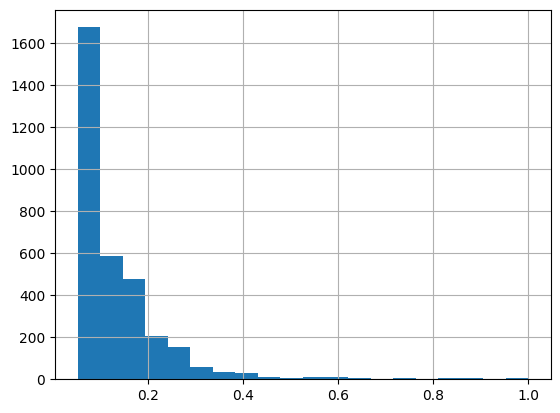

In [20]:
showcase(glob_few_ser)